# Regresión con SVM

Importar bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Cargar datos

In [2]:
# Cargar datos
df = pd.read_csv('../../datasets/churn/churn_data.csv')

1. Análisis exploratorio

In [3]:
print("Resumen estadístico:")
print(df.describe(include='all'))

print("\nValores nulos por columna:")
print(df.isnull().sum())

Resumen estadístico:
          country      city           name  signupDate lastLoginDate  \
count      200000    200000         200000      200000        200000   
unique         30       440         120324        1095          1088   
top     Indonesia  San Juan  Michael Smith  2022-06-25    2025-05-02   
freq         6839       925             86         223          1215   
mean          NaN       NaN            NaN         NaN           NaN   
std           NaN       NaN            NaN         NaN           NaN   
min           NaN       NaN            NaN         NaN           NaN   
25%           NaN       NaN            NaN         NaN           NaN   
50%           NaN       NaN            NaN         NaN           NaN   
75%           NaN       NaN            NaN         NaN           NaN   
max           NaN       NaN            NaN         NaN           NaN   

        subscriptionType  usageFrequency  watchTimePerWeek  preferredDevice  \
count      200000.000000   200000.0

Histograma de la variable objetivo

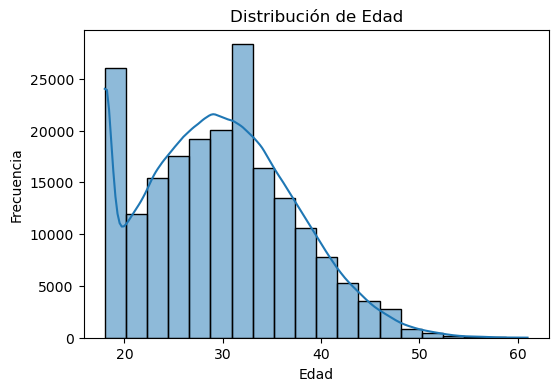

In [4]:
plt.figure(figsize=(6, 4))
sns.histplot(df['age'], bins=20, kde=True)
plt.title('Distribución de Edad')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.show()

Boxplot de edad por tipo de suscripción

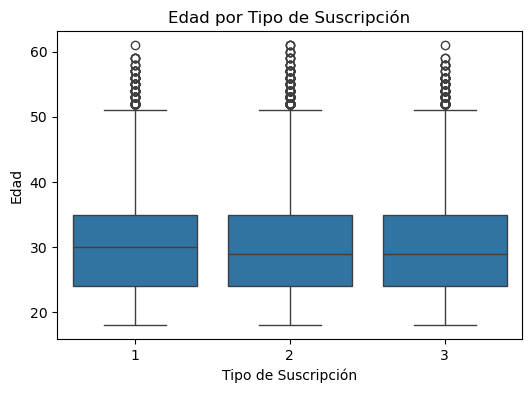

In [5]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x='subscriptionType', y='age')
plt.title('Edad por Tipo de Suscripción')
plt.xlabel('Tipo de Suscripción')
plt.ylabel('Edad')
plt.show()

Pairplot con algunas variables numéricas relevantes


<Figure size 640x480 with 0 Axes>

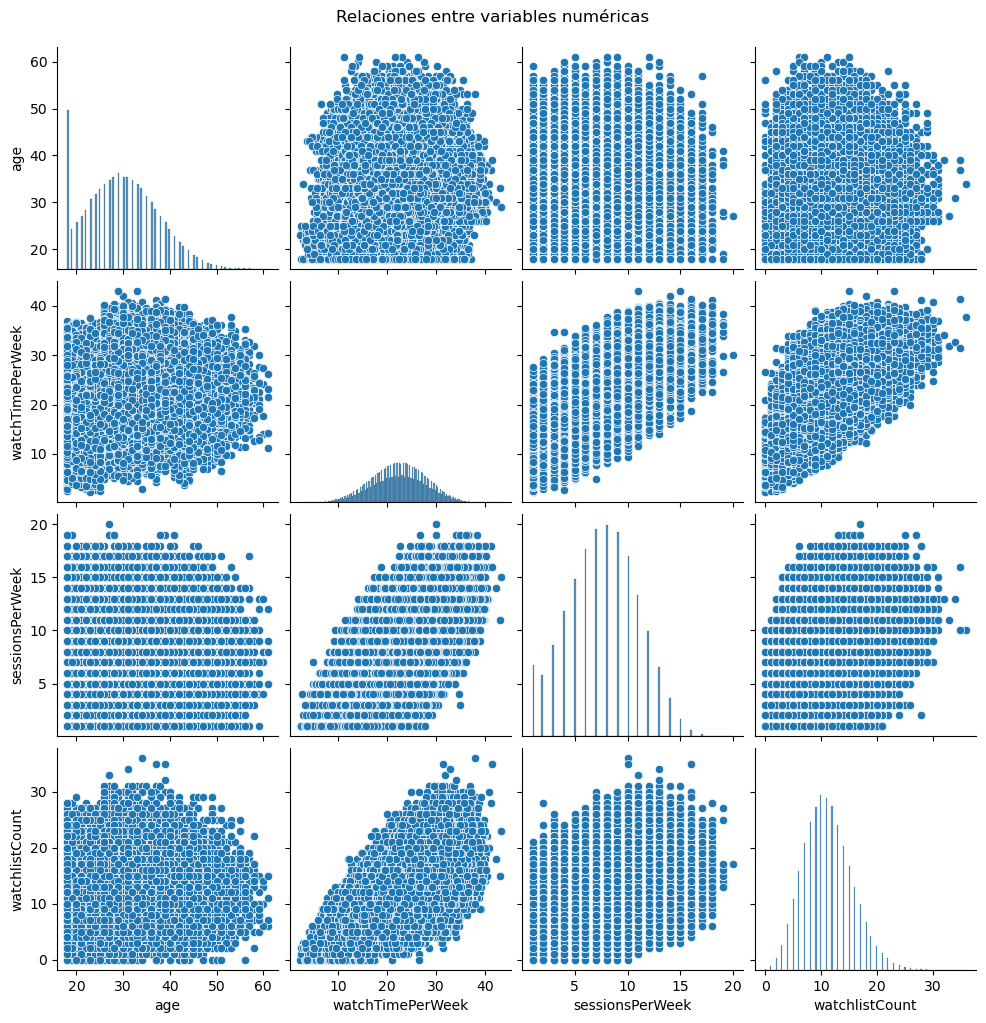

In [6]:
plt.figure()
sns.pairplot(df[['age', 'watchTimePerWeek', 'sessionsPerWeek', 'watchlistCount']])
plt.suptitle('Relaciones entre variables numéricas', y=1.02)
plt.show()

Heatmap de correlaciones

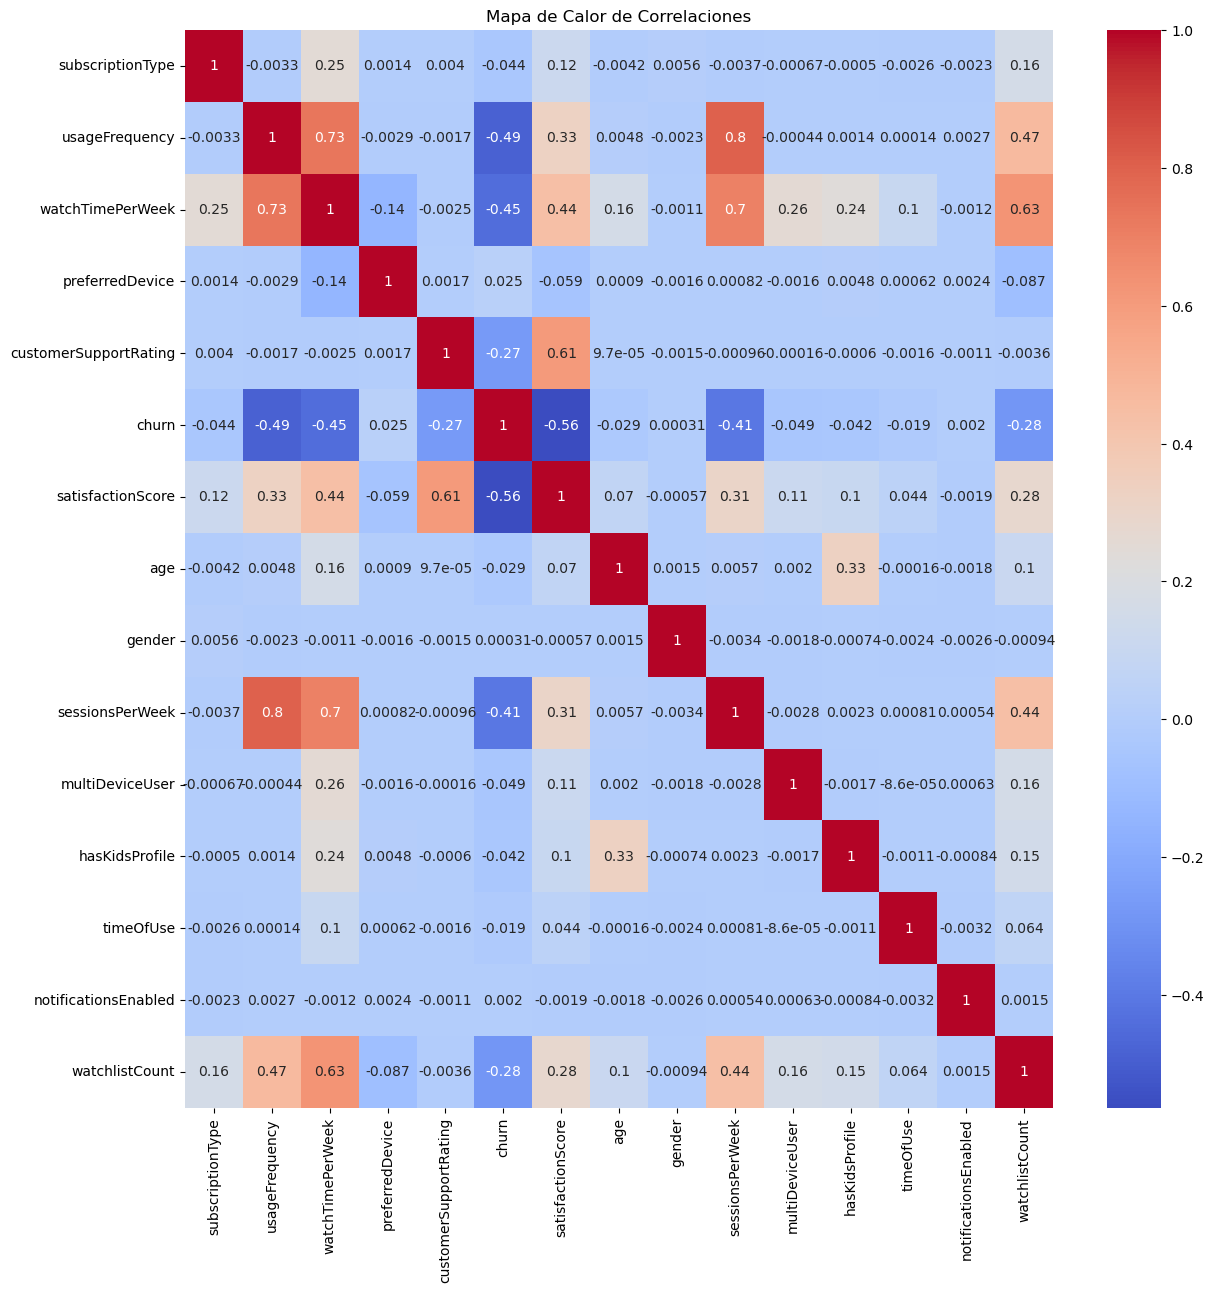

In [7]:
plt.figure(figsize=(14, 14))
sns.heatmap(df.select_dtypes(include=['int64', 'float64']).corr(), annot=True, cmap='coolwarm')
plt.title('Mapa de Calor de Correlaciones')
plt.show()

2. Limpieza de datos

Eliminar columnas que no aportan a la predicción

In [8]:
cols_to_drop = ['name', 'country', 'city', 'signupDate', 'lastLoginDate', 'gender']
df.drop(columns=cols_to_drop, inplace=True)

3. Transformación de variables

In [9]:
from scripts.categories import categories_map
df["preferred"] = df["preferredCategory"].apply(lambda x: categories_map.get(x, 0))
df["last_watched"] = df["lastWatchedCategory"].apply(lambda x: categories_map.get(x, 0))
df.drop(columns=['preferredCategory', 'lastWatchedCategory'], inplace=True)

{'Action': 0, 'Comedy': 1, 'Drama': 2, 'Documentary': 3, 'Kids': 4, 'Horror': 5, 'Sci-Fi': 6, 'Romance': 7, 'Western': 8}


4. Separación X e y

In [10]:
X = df.drop(columns=['watchTimePerWeek'])
y = df['watchTimePerWeek']

Dividir los datos


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

5. Preprocesamiento

In [12]:
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object']).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ])

6. Modelo y Pipeline

In [13]:
# Kernel: 'linear', 'rbf', 'poly', 'sigmoid'
svr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', SVR(kernel='linear', C=10, gamma='scale', epsilon=0.2))
])

In [ ]:
svr_pipeline.fit(X_train, y_train)

Predicciones

In [ ]:
y_pred = svr_pipeline.predict(X_test)

7. Evaluación

In [ ]:
print("\nEvaluación del modelo:")
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2:", r2_score(y_test, y_pred))

## Encontrar mejores parámetros

In [ ]:
param_grid = {
    'regressor__kernel': ['rbf', 'linear'],
    'regressor__C': [0.1, 1, 10],
    'regressor__epsilon': [0.1, 0.2, 0.5],
    'regressor__gamma': ['scale', 'auto']
}
grid_search = GridSearchCV(
    svr_pipeline,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

In [ ]:
grid_search.fit(X_train, y_train)

In [ ]:
print("Mejores hiperparámetros:", grid_search.best_params_)

In [ ]:
# Evaluación en test set
y_pred = grid_search.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2:", r2_score(y_test, y_pred))